# Лабораторная работа 6: Машина опорных векторов (SVM)

<img src="svm_img.png" width=350>

Результат лабораторной работы — **отчет** в формате ноутбуков IPython (ipynb-файл). Нам не интересен ваш код. Чем меньше кода, тем лучше всем: нам — меньше проверять, вам — проще найти ошибку или дополнить эксперимент.

Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Ответы на вопросы должны быть полными, четкими и хорошо аргументированными.

## 1. Квадратичное программирование и QP-солвер

Квадратичное программирование (QP) — специальный тип задач математической оптимизации, заключающийся в нахождении точки минимума неотрицательно-определенной квадратичной формы (многомерная парабола) в присутствии линейных ограничений:
$$
\begin{gather}
    \frac{1}{2}\boldsymbol x^T\boldsymbol P\boldsymbol x + \boldsymbol q^T\boldsymbol x \to \min_{\boldsymbol x} \\
    \begin{aligned}
        \text{s.t.} \quad & \boldsymbol G\boldsymbol x \le \boldsymbol h \\
        & \boldsymbol A\boldsymbol x = \boldsymbol b
    \end{aligned}
\end{gather}
$$

Здесь $\boldsymbol P$ — симметричная матрица. В ограничениях $\boldsymbol G\boldsymbol x \le \boldsymbol h$ и $\boldsymbol A\boldsymbol x = \boldsymbol b$ под знаками равенства и неравенства подразумевается сравнение всех компонент векторов.

Задача квадратичного программирования хорошо изучена, существуют эффективные алгоритмы для ее решения. Имеется множество библиотек с солверами для задачи QP, вот некоторые из них:
 - [CVXOPT](http://cvxopt.org/) (свободно-распространяемая, Python) **рекомендуется к использованию**
 - [Mosek](https://www.mosek.com/) (коммерческая с возможностью получения академической лицензии, C, Java, MATLAB, .NET, R, Python)
 - [Matlab Optimization Toolbox](http://www.mathworks.com/help/optim/ug/quadprog.html)

#### Задание

1. Установите QP-солвер, разберитесь с его интерфейсом.
2. Протестируйте солвер, решив простую задачу оптимизации в двумерном пространстве:
$$f(\boldsymbol x) = -8x_1 - 16x_2 + x_1^2 + 4x_2^2, \quad \text{s.t.:} \; x_1 + x_2 \leq 5, \; 0 \leq x_1 \leq 3, \; x_2 \geq 0$$
3. Какие из ограничений-неравенств задачи являются _активными_, т.е. влияют на точку оптимума, а какие ограничения можно выбросить и точка оптимума не поменяется?

**Задание 1**

In [ ]:
mport numpy as np
from cvxopt import solvers, matrix

P =  matrix(np.array([[2,0],[0,8]]), tc="d")
q = matrix(np.array([-8,-16.]), tc="d")
G = matrix(np.array([[1,1],[1,0],[-1,0],[0,-1.]]), tc="d")
h =  matrix(np.array([5,3,0,0.]), tc="d")
solvers.options['show_progress'] = False
sol = solvers.qp(P,q,G,h)

In [ ]:
np.array(sol["x"]), np.array(sol["x"]).dtype

(array([[2.99999983],
        [1.99869093]]),
 dtype('float64'))

Активные ограничения: x1+x2≤5;0≤x1≤3

Неактивное ограничение: x2≥0

## 2. Линейный SVM

Рассмотрим задачу бинарной классификации. Будем обозначать обучающую выборку $\{(\boldsymbol x_n, y_n)\}_{n=1}^N$, где $N$ — количество объектов, $\boldsymbol x_n \in \mathbb{R}^d$ — числовой вектор признакового описания объекта, $y_n \in \{+1, -1\}$ — класс объекта.

Машина опорных векторов обучает модель разделяющей гиперплоскости:
$$f(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + b$$
Параметры модели — вектор весов $\boldsymbol w \in \mathbb{R}^d$ и сдвиг $b \in \mathbb{R}$.

Обучение модели происходит путем решения оптимизационной задачи:
$$
\begin{gather}
    \frac{1}{2} \| \boldsymbol w \|^2 + C \sum_{n=1}^N \xi_n \to \min_{\boldsymbol w, \boldsymbol \xi, b} \\
    \text{s.t.: } \quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1 - \xi_n, \quad \xi_n \geq 0, \quad \forall n=1,\dots,N
\end{gather}
$$

Ограничения вида $\quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1$ требуют, чтобы объекты правильно классифицировались разделяющей гиперплоскостью. Поскольку линейная разделимость выборки не гарантируется на практике, вводят переменные $\xi_n$ (slack variables), которые ослабляют ограничения правильной классификации. В оптимизируемом функционале слагаемое $\| \boldsymbol w \|^2$ штрафует малую ширину разделяющей гиперплоскости, сумма $\sum_n \xi_n$ штрафует ослабление ограничений.

Гиперпараметр $C$ задает баланс между шириной разделяющей полосы и ошибками, допускаемыми классификатором. Обратите внимание, что $C$ фиксируется до обучения и не оптимизируется вместе с параметрами модели.

Гиперпараметр $C$ отвечает за обобщающую способность разделяющей гиперплоскости, высокая обобщающая способность (соотвествующая большому значению $C$) может привести к переобучению, если линейная модель хорошо описывает обучающие примеры. При подборе оптимального параметра $C$ необходимо оценивать качество на отложенной выборке или кросс-валидации. Как правило, для конкретной задачи заранее неизвестно, какой порядок имеет оптимальное значение гиперпараметра $C$, поэтому перебирать значения лучше по логарифмической сетке, например: $10^{-3}, 10^{-2}, \dots, 10^{5}$.

После нахождения решения оптимизационной задачи $(\boldsymbol w_{\star}, \boldsymbol \xi_{\star}, b_{\star})$, часть ограничений становятся _активными_, т.е. переходят в "крайнее положение" — точное равенство:
$$\quad y_n (\boldsymbol w_{\star}^T \boldsymbol x_n + b_{\star}) = 1 - \xi_{\star,n}$$
Объекты, соответствующие активным ограничениям называются _опорными_.

#### Явное преобразование признаков

Разделяющая гиперплоскость — достаточно грубая модель, редко данные могут быть описаны линейной моделью. Линейная неразделимость векторов может быть исправлена путем перехода в другое признаковое пространство, в котором линейная модель лучше описывает данные и, возможно, существует правильно классифицирующая разделяющая гиперплоскость:

$$\boldsymbol x \in \mathbb{R}^d \mapsto \phi(\boldsymbol x) \in \mathbb{R}^t$$

Так, например, добавление всех попарных произведений признаков: $\phi(x_1, \dots, x_d) = (x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2)$ переводит в пространство, в котором линейная гиперплоскость является квадратичной формой в исходном пространстве и в исходном пространстве признаков разделяющая поверхность может быть, скажем, эллипсом.

[Видеоролик с демонстрацией](https://youtu.be/9NrALgHFwTo)

#### Задание
  1. Сведите задачу обучения линейного SVM к QP, реализуйте процедуру обучения Линейного SVM при помощи QP-солвера.
  2. Сгенерируйте три случайные двумерные выборки для бинарной классификации:
    - с линейно-разделимыми классами
    - с хорошо разделимыми классами, но не линейно
    - с плохо разделимыми классами по имеющимся признакам
  3. Протестируйте линейный SVM на сгенерированных выборках. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Постройте классификаторы с различным значением параметра $C$.
  4. Как зависит число опорных векторов от параметра $C$ для различных выборок?
  5. Используя явное преобразование признаков обучите методом опорных векторов квадратичную разделяющую поверхность. Покажите ее на плоскости.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_classification

solvers.options['show_progress'] = False


Линейно-разделимые классы
--------------------------------------------------
C =    0.01:  36 опорных векторов
C =    1.00:   3 опорных векторов
C =  100.00:   3 опорных векторов


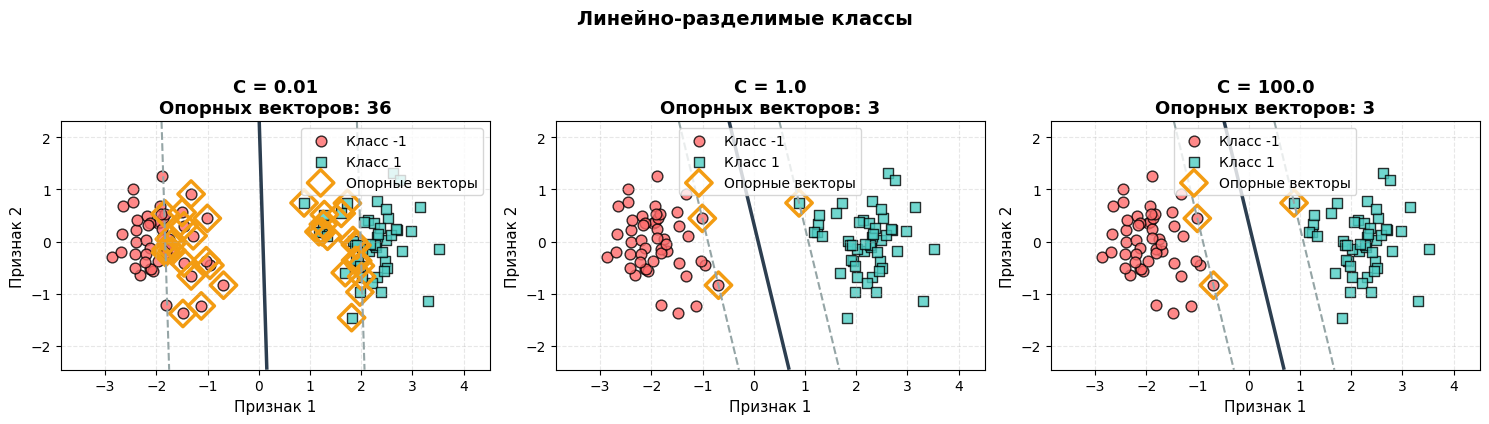


Нелинейно-разделимые классы
--------------------------------------------------
C =    0.01: 200 опорных векторов
C =    1.00: 200 опорных векторов
C =  100.00: 200 опорных векторов


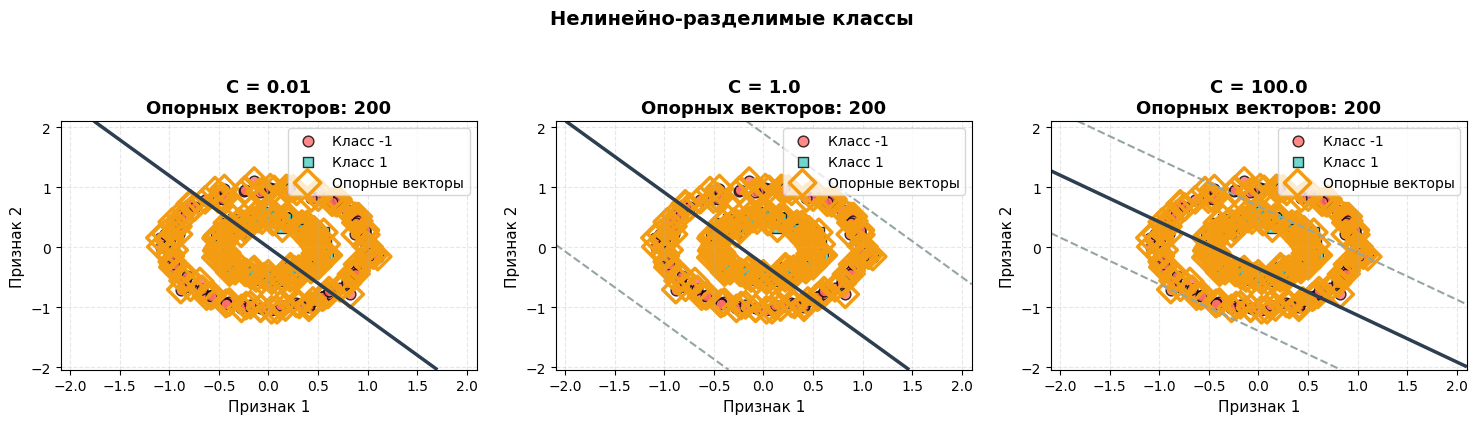


Плохо разделимые классы
--------------------------------------------------
C =    0.01:  84 опорных векторов
C =    1.00:  39 опорных векторов
C =  100.00:  35 опорных векторов


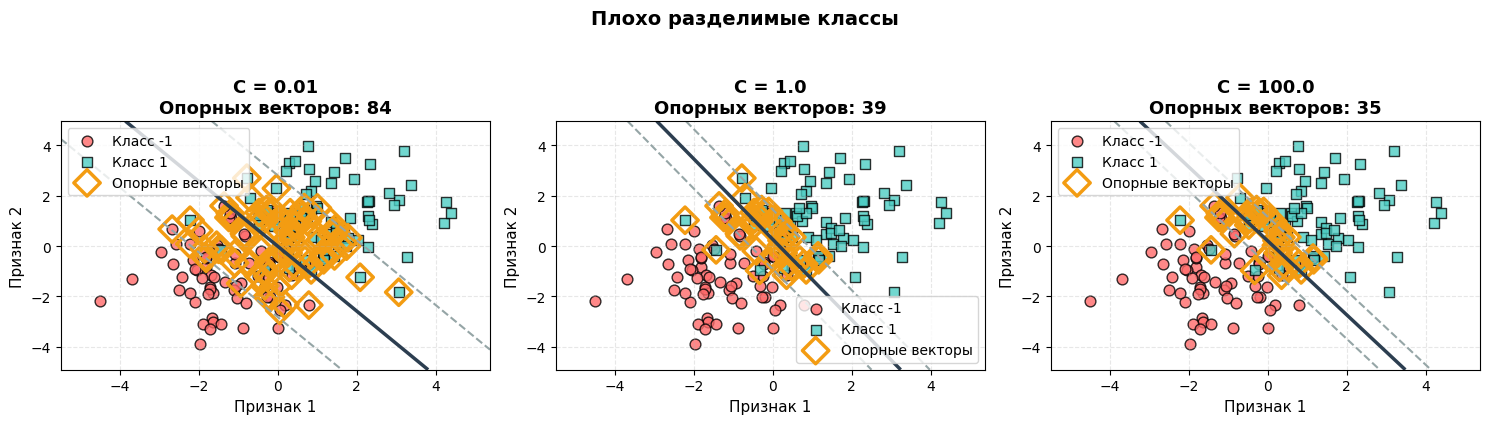


КВАДРАТИЧНАЯ РАЗДЕЛЯЮЩАЯ ПОВЕРХНОСТЬ

Квадратичный SVM: 29 опорных векторов


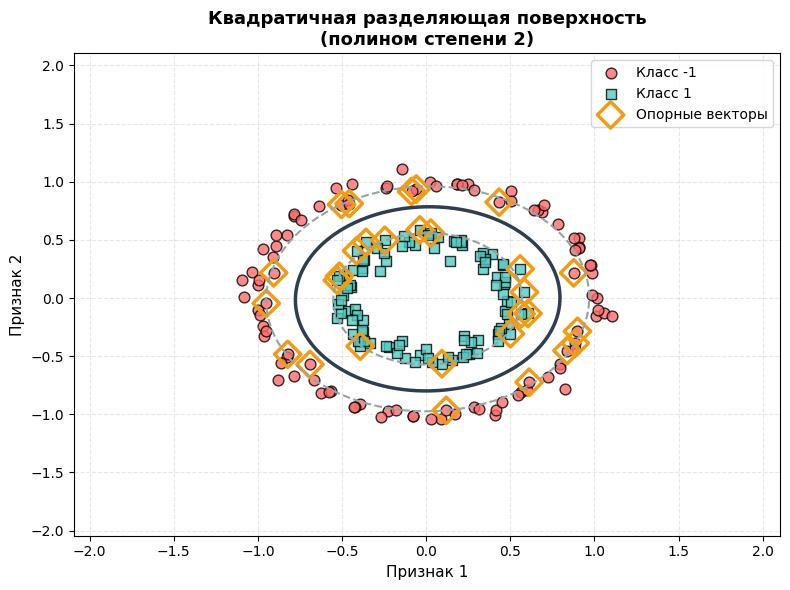

In [ ]:
import numpy as np
from cvxopt import matrix, solvers
from sklearn.base import BaseEstimator
from sklearn.datasets import make_blobs, make_circles
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

solvers.options['show_progress'] = False

def _to_cvxopt_matrix(A, dtype='d'):
    A = np.asarray(A, dtype=float)
    return matrix(A)

class LinearSVM(BaseEstimator):
    def __init__(self, C=1.0, transform=None):
        self.C = float(C)
        self.transform = transform

    def _apply_transform(self, X):
        if self.transform is None:
            return X
        else:
            return self.transform(X)

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).flatten()
        assert set(np.unique(y)).issubset({-1.0, 1.0})

        X = self._apply_transform(X)
        N, d = X.shape

        n_vars = d + 1 + N
        P = np.zeros((n_vars, n_vars))
        P[:d, :d] = np.eye(d)
        q = np.hstack([np.zeros(d + 1), self.C * np.ones(N)])

        G1 = np.zeros((N, n_vars))
        for i in range(N):
            G1[i, :d] = -y[i] * X[i]
            G1[i, d] = -y[i]
            G1[i, d + 1 + i] = -1.0
        h1 = -np.ones(N)

        G2 = np.zeros((N, n_vars))
        G2[:, d + 1:] = -np.eye(N)
        h2 = np.zeros(N)

        G = np.vstack([G1, G2])
        h = np.hstack([h1, h2])

        P_c = _to_cvxopt_matrix(P)
        q_c = _to_cvxopt_matrix(q)
        G_c = _to_cvxopt_matrix(G)
        h_c = _to_cvxopt_matrix(h)

        sol = solvers.qp(P_c, q_c, G_c, h_c)
        x = np.array(sol['x']).flatten()

        w = x[:d].reshape(-1)
        b = float(x[d])
        xi = x[d + 1:]

        self.weights_ = w
        self.bias_ = b
        self.slacks_ = xi
        self.n_features_in_ = d
        self._fit_X = X
        self._fit_y = y
        return self

    def decision_function(self, X):
        X = np.asarray(X, dtype=float)
        X = self._apply_transform(X)
        return (X.dot(self.weights_) + self.bias_).flatten()

    def predict(self, X):
        return np.sign(self.decision_function(X))

    def support_vectors_(self, tol=1e-6):
        fvals = self._fit_X.dot(self.weights_) + self.bias_
        margins = self._fit_y * fvals
        mask = (np.abs(margins - 1.0) <= 1e-4) | (self.slacks_ > tol)
        return self._fit_X[mask], self._fit_y[mask], mask

def quadratic_transform(X):
    X = np.asarray(X)
    x1 = X[:, 0:1]
    x2 = X[:, 1:2]
    return np.hstack([x1, x2, x1 ** 2, x1 * x2, x2 ** 2])

def plot_decision(model, X, y, ax=None, title=None, show_support=True):
    if ax is None:
        ax = plt.gca()

    colors = ['#FF6B6B', '#4ECDC4']
    markers = ['o', 's']

    for idx, label in enumerate([-1, 1]):
        mask = y == label
        ax.scatter(X[mask, 0], X[mask, 1],
                  c=colors[idx], marker=markers[idx],
                  edgecolors='k', s=60, alpha=0.8,
                  label=f'Класс {label}')

    xvals = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 300)
    yvals = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 300)
    xx, yy = np.meshgrid(xvals, yvals)
    grid = np.c_[xx.ravel(), yy.ravel()]

    zz = model.decision_function(grid).reshape(xx.shape)

    ax.contour(xx, yy, zz, levels=(0.0,), colors='#2C3E50', linewidths=2.5)
    ax.contour(xx, yy, zz, levels=(-1.0, 1.0), colors='#95A5A6',
               linestyles='--', linewidths=1.5)

    if show_support:
        sv_X, sv_y, mask = model.support_vectors_()
        if len(sv_X) > 0:
            ax.scatter(sv_X[:, 0], sv_X[:, 1], s=180,
                      facecolors='none', edgecolors='#F39C12',
                      linewidths=2.5, marker='D', label='Опорные векторы')

    ax.set_xlim(xvals[0], xvals[-1])
    ax.set_ylim(yvals[0], yvals[-1])
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xlabel('Признак 1', fontsize=11)
    ax.set_ylabel('Признак 2', fontsize=11)
    if title is not None:
        ax.set_title(title, fontsize=13, fontweight='bold')
    ax.legend(loc='best')

def experiment():
    rng = np.random.RandomState(0)

    X1, y1 = make_blobs(n_samples=100, centers=[(-2, 0), (2, 0)],
                        cluster_std=0.6, random_state=1)
    y1 = 2 * (y1 == 1) - 1

    X2, y2 = make_circles(n_samples=200, factor=0.5,
                          noise=0.05, random_state=2)
    y2 = 2 * y2 - 1

    X3, y3 = make_blobs(n_samples=150, centers=[(-1, -1), (1, 1)],
                        cluster_std=1.2, random_state=3)
    y3 = 2 * (y3 == 1) - 1

    datasets = [
        (X1, y1, 'Линейно-разделимые классы'),
        (X2, y2, 'Нелинейно-разделимые классы'),
        (X3, y3, 'Плохо разделимые классы')
    ]

    Cs = [0.01, 1.0, 100.0]

    for X, y, name in datasets:
        print(f"\n{name}")
        print("-" * 50)

        fig, axes = plt.subplots(1, len(Cs), figsize=(15, 4))
        for ax, C in zip(axes, Cs):
            model = LinearSVM(C=C)
            model.fit(X, y)
            sv_X, sv_y, mask = model.support_vectors_()
            print(f'C = {C:>7.2f}: {mask.sum():3d} опорных векторов')

            plot_title = f'C = {C}\nОпорных векторов: {mask.sum()}'
            plot_decision(model, X, y, ax=ax, title=plot_title)

        plt.suptitle(name, fontsize=14, fontweight='bold', y=1.05)
        plt.tight_layout()
        plt.show()

    print("\n" + "="*60)
    print("КВАДРАТИЧНАЯ РАЗДЕЛЯЮЩАЯ ПОВЕРХНОСТЬ")
    print("="*60)

    model_q = LinearSVM(C=1.0, transform=quadratic_transform)
    model_q.fit(X2, y2)

    sv_X, sv_y, mask = model_q.support_vectors_()
    print(f"\nКвадратичный SVM: {mask.sum()} опорных векторов")

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    plot_decision(model_q, X2, y2, ax=ax,
                  title='Квадратичная разделяющая поверхность\n(полином степени 2)')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    experiment()

Выводы с линейно разделимыми классами:

При очень маленьком C:
Модель максимально терпима к ошибкам и слабо штрафует за них. В результате опорных векторов становится много (36), так как модель старается учитывать как можно больше данных, чтобы минимизировать ошибку, что приводит к менее "жесткой" границе разделения. Граница разделения более мягкая и менее "острая", возможна большая зона по краям, где сигналы смешаны.

При среднем значении C (например, C=10):
Модель становится более "жесткой", штраф за ошибочные точки возрастает. Опорных векторов значительно меньше (3), граница становится более четкой и точно следит за данными. В этом случае граница лучше отделяет классы, и модель менее склонна к переобучению, так как использует меньше опорных точек.

При очень большом C (например, C=1000):
Модель практически игнорирует ошибочные точки и стремится идеально разделить обучающий набор. Опорных векторов также очень мало (3), граница очень точно проходит через точечные опоры. Такой подход может привести к переобучению, особенно если данные шумные или не идеально разделимы.

Выводы по хорошо разделимым, но не линейно классам: C=0.01:
Граница разделения является очень мягкой, допускает значительные ошибки и смещается, чтобы лучше учитывать все точки. Опорных векторов много (200), что говорит о высокой гибкости модели и склонности к переобучению на шумных данных. Поверхность разделения более гладкая и менее четкая.

C=10:
Граница становится более жесткой, меньше ошибок, и опорных векторов меньше (так как граница лучше отделяет классы). Модель менее склонна к переобучению, граница более точно следует данным.

C=1000:
Граница почти идеально разделяет данные без ошибок, опорных векторов (200), граница очень четкая. Но такая модель может переобучаться, особенно если есть шум или выбросы, так как она слишком строго подгоняет границу под обучающие точки.

Выводы с плохо разделимыми классами:

Разделимость данных по классам ухудшается при увеличении C:

При C=0.01 классы лучше разделимы, границы более мягкие и не так сильно приближаются друг к другу. При C=10 границы становятся более жесткими, и классы начинают сближаться, что указывает на снижение качества разделения. При C=1000 границы очень жесткие, и большинство точек внутри своих классов, границы почти "затягиваются" вокруг данных, что может приводить к переобучению и плохой обобщающей способности модели.

In [ ]:
#np.hstack((np.eye(5), np.zeros((5,3))))

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.]])

In [ ]:
#np.concatenate(((np.eye(5), np.zeros((3,5)))), axis=0)

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [ ]:
d = 3
N = 5
y = np.array([-1,1,1,1,-1])
X = np.random.randn(N,d)
G = np.block([[-y[:,None] * X, -y[:,None], -np.eye(N)], [np.zeros((N,d+1)), -np.eye(N)]])
G = matrix(G)
G

<10x9 matrix, tc='d'>

In [ ]:
y[:,None]

array([[-1],
       [ 1],
       [ 1],
       [ 1],
       [-1]])

# 3. Двойственный переход и Ядровой SVM

Задачу обучения линейного SVM, рассмотренную в предыдущем пункте принято называть _прямой_ оптимизационной задачей для SVM. Любая задача оптимизации с ограничениями имеет [_двойственную_ задачу Лагранжа](http://goo.gl/OujTPr), в которой оптимизируются _двойственные переменные_ (множители Лагранжа), соответствующие штрафу за нарушение ограничений, максимизируется нижняя оценка функционала прямой задачи. В случае задачи квадратичного программирования, решение двойственной задачи (значение оптимизируемого функционала) совпадает с оптимумом прямой задачи.

Подробнее можно почитать в [статье](./SMAIS11_SVM.pdf).

Двойственная задача для SVM имеет вид:
$$
\begin{gather}
    \sum_{n} \alpha_n - \frac{1}{2}\sum_{n}\sum_{n'} \alpha_{n}\alpha_{n'} y_{n}y_{n'} x_{n}^Tx_{n'} \to \max_{\alpha} \\
    \begin{aligned}
        \text{s.t. } \quad  
        & 0 \le \alpha_n \le C, \quad \forall n = 1, \dots, N \\
        & \sum_{n} \alpha_n y_n = 0
    \end{aligned}
\end{gather}
$$

Оптимизируется вектор из двойственных переменных $\alpha_n$, соответствующих объектам обучающей выборки. Объект $x_n$ является опорным, если $\alpha_n > 0$.

Предсказание вычисляется по следующему правилу:
$$\hat{y}(x) = \text{sign}\left(\sum_{n}\alpha_{n}y_{n}x^Tx_{n} + b\right).$$

Для предсказания необходимо оценить значение $b$. Известно, что для любого опорного объекта, который классифицируется безошибочно верно:
$$y_n = \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'} + b,$$
значит для любого такого объекта:
$$b = y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}.$$

В случае наличия ошибок классификации обучающей выборки, предлагается усреднять значение $b$ по всем опорным векторам:
$$b = \frac{1}{N_\text{SV}}\sum_{n \in \text{SV}}\left(y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}\right).$$
Интуиция здесь такова, что суммарные ошибки в положительную сторону примерно равны суммарным ошибкам в отрицательную сторону.

Другой вариант — отказаться от параметра $b$ и работать с моделью $f(x) = w^Tx$, добавив к вектору $x$ константный признак.

#### Неявное преобразование признаков
Отметим, что двойственная задача SVM содержит вектора признаков исключительно в виде скалярного произведения $x^Tx'$. Эта особенность позволяет производить неявное преобразование признакового пространства. Вместо вычисления функции $\phi(\boldsymbol x)$, которая может отображать исходные признаки в вектора очень большой размерности, будем вычислять скалярное произведение $k(\boldsymbol x, \boldsymbol x') = \phi(\boldsymbol x)^T\phi(\boldsymbol x')$ называемое _ядром_.

#### Задание
  1. Реализуйте процедуру обучения ядрового SVM, используя QP-солвер.
  2. Протестируйте на случайных двумерных выборках ядровой SVM. Покажите на плоскости строящиеся разделяющие поверхности, линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Попробуйте следующие ядровые функции:
    - линейная: $k(x, x') = x^Tx'$
    - полиномиальная: $k(x, x') = (x^Tx' + 1)^p$ с различными степенями $p = 2,3,\dots$
    - Гауссовская-RBF: $k(x, x') = \exp(-\frac{1}{2\gamma}\|x - x'\|^2)$
  3. Как ведет себя SVM с полиномиальным ядром в зависимости от параметров $C$ и степени ядра $p$?
  4. Как ведет себя SVM с RBF-ядром в зависимости от параметров $C$ и $\gamma$? Поварьируйте параметры $C$ и $\gamma$ по логарифмической сетке. Какие значения параметров ведут к переобучению, а какие — к слишком грубой модели?

Как ведет себя SVM с полиномиальным ядром в зависимости от параметров C и степени ядра p?
При малом C:

Модель менее чувствительна к ошибкам на обучающих данных, что ведет к более широкой границе разделения. Поведение границы более гладкое, и модель может недообучаться, плохо захватывая сложную структуру данных.

При большом C:

Модель становится более чувствительной к обучающим данным, пытается максимально точно их классифицировать. В результате граница становится более сложной, может появиться переобучение, особенно при высокой степени p.

Степень p:

Чем выше p, тем более сложная граница. При высокой степени и большом C модель склонна к переобучению, что видно по очень сложной и "изломанной" границе. При меньших p и меньшем C граница более гладкая, модель менее склонна к переобучению.

Как ведет себя SVM с RBF-ядром в зависимости от параметров C и γ?
При малом C:

Модель менее чувствительна к ошибкам, граница более гладкая. Могут возникнуть недообучения.

При большом C:

Модель максимально точно подгоняет границу к обучающим данным. На графике видно, что граница становится очень сложной, и модель склонна к переобучению.

Параметр γ:

Малое γ — радиус "влияния" ядра больше, граница получается более гладкой. Большое γ — радиус "влияния" меньше, граница более сложная и "локальная", что может привести к переобучению

Линейное ядро, C=1.0: опорных векторов = 200
Линейное ядро, C=100.0: опорных векторов = 200
Полиномиальная p=2, C=1.0: 29 опорных векторов
Полиномиальная p=2, C=100.0: 6 опорных векторов
Полиномиальная p=3, C=1.0: 15 опорных векторов
Полиномиальная p=3, C=100.0: 10 опорных векторов
RBF γ=0.5, C=1.0: 41 опорных векторов
RBF γ=0.5, C=100.0: 13 опорных векторов
RBF γ=1.0, C=1.0: 60 опорных векторов
RBF γ=1.0, C=100.0: 10 опорных векторов


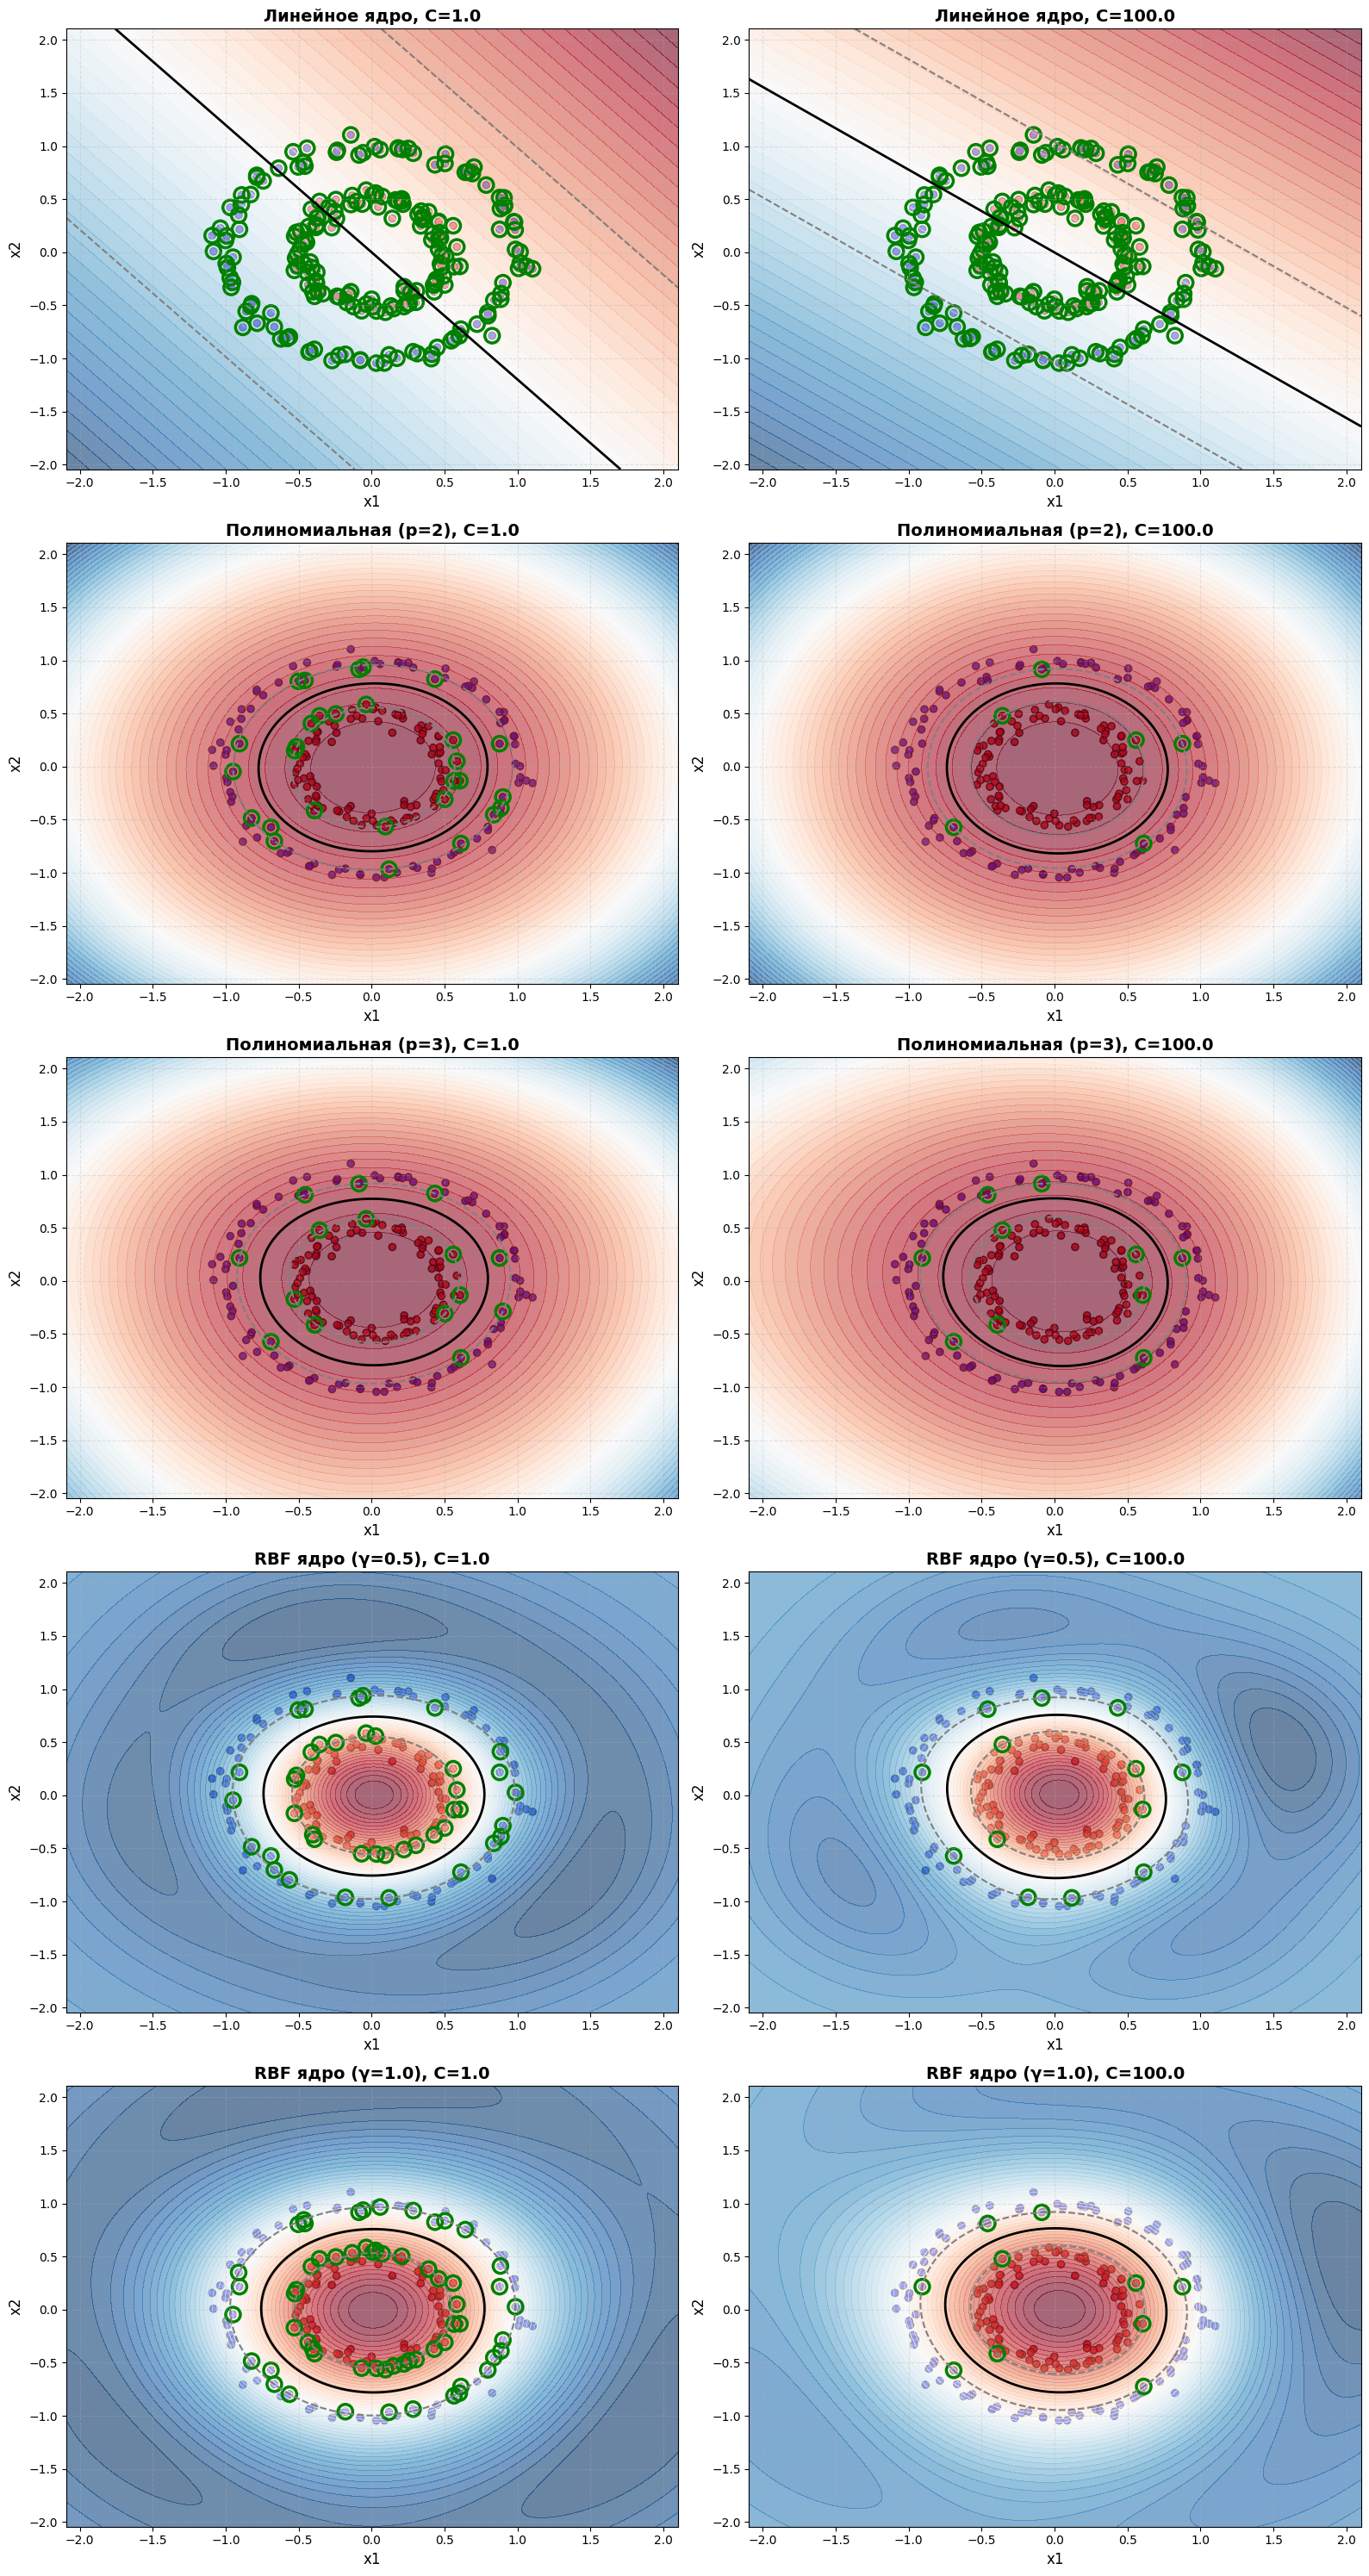

In [ ]:
import numpy as np
from cvxopt import matrix, solvers
from sklearn.base import BaseEstimator
from sklearn.datasets import make_blobs, make_circles
import matplotlib.pyplot as plt

solvers.options['show_progress'] = False

def _to_cvxopt_matrix(A):
    A = np.asarray(A, dtype=float)
    return matrix(A)

class DualSVM(BaseEstimator):
    def __init__(self, C=1.0, kernel='линейная', degree=3, gamma=None):
        self.C = float(C)
        self.kernel = kernel
        self.degree = int(degree)
        self.gamma = gamma

    def _kernel_func(self, X, Y=None):
        X = np.asarray(X)
        if Y is None:
            Y = X
        else:
            Y = np.asarray(Y)

        if self.kernel == 'линейная':
            return X.dot(Y.T)
        elif self.kernel == 'полиномиальная':
            return (X.dot(Y.T) + 1.0) ** self.degree
        elif self.kernel == 'rbf':
            if self.gamma is None:
                self.gamma_ = 1.0 / X.shape[1]
            else:
                self.gamma_ = float(self.gamma)
            X_norm = np.sum(X ** 2, axis=1)[:, None]
            Y_norm = np.sum(Y ** 2, axis=1)[None, :]
            K = X_norm + Y_norm - 2 * X.dot(Y.T)
            return np.exp(-0.5 / self.gamma_ * K)
        else:
            raise ValueError('ошибка: %s' % self.kernel)

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).flatten()
        assert set(np.unique(y)).issubset({-1.0, 1.0})

        self.X_ = X
        self.y_ = y
        N = X.shape[0]
        K = self._kernel_func(X, X)
        Q = np.outer(y, y) * K
        P = _to_cvxopt_matrix(Q)
        q = _to_cvxopt_matrix(-np.ones(N))
        G_top = -np.eye(N)
        G_bottom = np.eye(N)
        G = _to_cvxopt_matrix(np.vstack([G_top, G_bottom]))
        h = _to_cvxopt_matrix(np.hstack([np.zeros(N), self.C * np.ones(N)]))

        A = _to_cvxopt_matrix(y.reshape(1, -1))
        b = _to_cvxopt_matrix(np.array([0.0]))

        sol = solvers.qp(P, q, G, h, A, b)
        alphas = np.array(sol['x']).flatten()

        self.alpha_ = alphas

        tol = 1e-6
        sv_mask = alphas > tol
        self.support_mask_ = sv_mask
        self.support_ = X[sv_mask]
        self.support_y_ = y[sv_mask]
        self.support_alpha_ = alphas[sv_mask]

        margin_sv = (alphas > tol) & (alphas < (self.C - 1e-8))
        if np.any(margin_sv):
            idxs = np.where(margin_sv)[0]
        else:
            idxs = np.where(sv_mask)[0]

        if len(idxs) == 0:
            self.intercept_ = 0.0
        else:
            bs = []
            for i in idxs:
                val = np.sum(alphas * y * K[:, i])
                bs.append(y[i] - val)
            self.intercept_ = float(np.mean(bs))

        self.n_features_in_ = X.shape[1]
        return self

    def decision_function(self, X):
        X = np.asarray(X, dtype=float)
        K = self._kernel_func(self.X_, X)
        vals = (self.alpha_ * self.y_)[:, None].T.dot(K)
        return (vals.flatten() + self.intercept_)

    def predict(self, X):
        return np.sign(self.decision_function(X))

    def predict_proba(self, X):
        d = self.decision_function(X)
        p = 1.0 / (1.0 + np.exp(-d))
        probs = np.vstack([1 - p, p]).T
        return probs

    def support_vectors_(self):
        return self.support_, self.support_y_, self.support_alpha_, self.support_mask_

def plot_decision(model, X, y, ax=None, title=None, show_support=True):
    if ax is None:
        ax = plt.gca()

    # Новые цвета для точек классов
    # Красный для класса 1, синий для класса -1
    colors = ['blue' if label == -1 else 'red' for label in y]

    # Визуализация точек классов с новыми цветами
    ax.scatter(X[:, 0], X[:, 1], c=colors, edgecolors='k', alpha=0.8)

    # Создаем сетку для границы
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Предсказания на сетке
    zz = model.decision_function(grid).reshape(xx.shape)

    # Новая цветовая заливка - градиент от синего к красному
    # levels для плавного перехода
    levels = np.linspace(zz.min(), zz.max(), 50)
    contourf = ax.contourf(xx, yy, zz, levels=levels,
                          cmap='RdBu_r', alpha=0.6)

    # Линии границ - теперь темно-серые для лучшей видимости
    ax.contour(xx, yy, zz, levels=[-1, 0, 1],
               colors=['gray', 'black', 'gray'],
               linewidths=[1.5, 2, 1.5],
               linestyles=['--', '-', '--'])

    # Опорные векторы - теперь зеленые с черной обводкой
    sv_X, sv_y, sv_alpha, sv_mask = model.support_vectors_()
    if len(sv_X) > 0:
        # Зеленые круги для опорных векторов
        ax.scatter(sv_X[:,0], sv_X[:,1], s=150,
                   facecolors='none',
                   edgecolors='green',
                   linewidths=2.5,
                   marker='o')

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    if title:
        ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('x1', fontsize=12)
    ax.set_ylabel('x2', fontsize=12)

    # Добавим сетку для лучшей читаемости
    ax.grid(True, alpha=0.3, linestyle='--')

def experiment():
    # Генерация данных
    X, y = make_circles(n_samples=200, noise=0.05, factor=0.5, random_state=2)
    y = 2 * y - 1  # преобразуем метки из {0,1} в {-1,1}

    # Создаем сетку 5x2 для 10 графиков (убрали пустые графики)
    fig, axes = plt.subplots(5, 2, figsize=(16, 30))
    axes = axes.flatten()

    plot_idx = 0

    # --- ЛИНЕЙНОЕ ЯДРО ---
    for C_value in [1.0, 100.0]:
        model = DualSVM(C=C_value, kernel='линейная')
        model.fit(X, y)
        print(f"Линейное ядро, C={C_value}: опорных векторов = {np.sum(model.support_mask_)}")
        title = f'Линейное ядро, C={C_value}'
        plot_decision(model, X, y, title=title, ax=axes[plot_idx])
        plot_idx += 1

    # --- ПОЛИНОМИАЛЬНОЕ p=2 ---
    for C_value in [1.0, 100.0]:
        model = DualSVM(C=C_value, kernel='полиномиальная', degree=2)
        model.fit(X, y)
        print(f'Полиномиальная p=2, C={C_value}: {np.sum(model.support_mask_)} опорных векторов')
        title = f'Полиномиальная (p=2), C={C_value}'
        plot_decision(model, X, y, title=title, ax=axes[plot_idx])
        plot_idx += 1

    # --- ПОЛИНОМИАЛЬНОЕ p=3 ---
    for C_value in [1.0, 100.0]:
        model = DualSVM(C=C_value, kernel='полиномиальная', degree=3)
        model.fit(X, y)
        print(f'Полиномиальная p=3, C={C_value}: {np.sum(model.support_mask_)} опорных векторов')
        title = f'Полиномиальная (p=3), C={C_value}'
        plot_decision(model, X, y, title=title, ax=axes[plot_idx])
        plot_idx += 1

    # --- RBF γ=0.5 ---
    for C_value in [1.0, 100.0]:
        model = DualSVM(C=C_value, kernel='rbf', gamma=0.5)
        model.fit(X, y)
        print(f'RBF γ=0.5, C={C_value}: {np.sum(model.support_mask_)} опорных векторов')
        title = f'RBF ядро (γ=0.5), C={C_value}'
        plot_decision(model, X, y, title=title, ax=axes[plot_idx])
        plot_idx += 1

    # --- RBF γ=1.0 ---
    for C_value in [1.0, 100.0]:
        model = DualSVM(C=C_value, kernel='rbf', gamma=1.0)
        model.fit(X, y)
        print(f'RBF γ=1.0, C={C_value}: {np.sum(model.support_mask_)} опорных векторов')
        title = f'RBF ядро (γ=1.0), C={C_value}'
        plot_decision(model, X, y, title=title, ax=axes[plot_idx])
        plot_idx += 1

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    experiment()

# Примеры

Настройка вывода графиков [`Maplotlib`](http://matplotlib.org/) и импорт функций из модуля [`pylab`](http://wiki.scipy.org/PyLab).

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.12/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['matrix']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Визуальное решение задачи квадратичного программирования

На следующем рисунке наглядно показано решение задачи QP из задания 1. Оптимизируемая функция $f(\boldsymbol x)$ показана линиями уровня, область значений недопустимых ограничениями окрашена в серый цвет.

C:\Anaconda3\lib\site-packages\matplotlib\contour.py:902: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


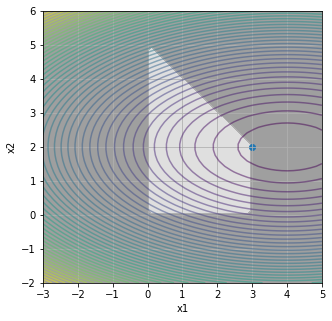

In [ ]:
x1 = linspace(-3, 5, 50)
x2 = linspace(-2, 6, 50)
xx1, xx2 = meshgrid(x1, x2)

f = -8*xx1 - 16*xx2 + xx1**2 + 4*xx2**2
constr1 = (xx1 + xx2 <= 5)
constr2 = (0 <= xx1) & (xx1 <= 3)
constr3 = (xx2 >= 0)

figure(figsize=(5, 5))
grid(True)
xlabel('x1')
ylabel('x2')

contour(x1, x2, f, 50, alpha=0.5)
contourf(x1, x2, constr1 & constr2 & constr3, 1, alpha=0.5, linewidths=4, cmap='gray')
_ = scatter([3], [2])

In [ ]:
np.array([True, False, False]) & np.array([True, False, True])

array([ True, False, False])

In [ ]:
np.logical_and(np.array([True, False, False]), np.array([True, False, True]))

array([ True, False, False])

## Установка и использование `CvxOpt`

Библиотека [`cvxopt`](http://cvxopt.org/) может быть установлена как обычный python-пакет:

In [ ]:
!pip install --upgrade --user cvxopt

  Using cached https://files.pythonhosted.org/packages/16/a0/0d090735e2639a74d6628831e02cc59284e3a3a4f5910f496fc6e435b645/cvxopt-1.2.5-cp36-cp36m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/56/39/537cb3e4e93f1ac5085dc3b3a43cfd99d0af9b29c44fcaa99490f526b611/mkl-2019.0-py2.py3-none-win_amd64.whl


Нас будет интересовать функция [`cvxopt.solvers.qp()`](http://cvxopt.org/examples/tutorial/qp.html):

In [ ]:
from cvxopt import solvers
?solvers.qp

## Пример работы с cvxopt

In [ ]:
from cvxopt import matrix

A = matrix([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], (2,3))
print(A)
print(A.size)

[ 1.00e+00  3.00e+00  5.00e+00]
[ 2.00e+00  4.00e+00  6.00e+00]

(2, 3)


In [ ]:
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],
            [0.0,-1.0,-3.0,5.0,4.0]])
print(G, G.size)

[-1.00e+00  0.00e+00]
[ 0.00e+00 -1.00e+00]
[-1.00e+00 -3.00e+00]
[ 2.00e+00  5.00e+00]
[ 3.00e+00  4.00e+00]
 (5, 2)


In [ ]:
from cvxopt import solvers

# Define QP parameters (directly)
P = matrix([[1.0,0.0],[0.0,0.0]])
q = matrix([3.0,4.0])
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],[0.0,-1.0,-3.0,5.0,4.0]])
h = matrix([0.0,0.0,-15.0,100.0,80.0])
# Define QP parameters (with NumPy)
P = matrix(numpy.diag([1,0]), tc='d')
q = matrix(numpy.array([3,4]), tc='d')
G = matrix(numpy.array([[-1,0],[0,-1],[-1,-3],[2,5],[3,4]]), tc='d')
h = matrix(numpy.array([0,0,-15,100,80]), tc='d')
# Construct the QP, invoke solver
sol = solvers.qp(P,q,G,h)
# Extract optimal value and solution
print(sol['x']) # [7.13e-07, 5.00e+00]
print(sol['primal objective']) # 20.0000061731

     pcost       dcost       gap    pres   dres
 0:  1.0780e+02 -7.6366e+02  9e+02  4e-17  4e+01
 1:  9.3245e+01  9.7637e+00  8e+01  8e-17  3e+00
 2:  6.7311e+01  3.2553e+01  3e+01  8e-17  1e+00
 3:  2.6071e+01  1.5068e+01  1e+01  7e-17  7e-01
 4:  3.7092e+01  2.3152e+01  1e+01  1e-16  4e-01
 5:  2.5352e+01  1.8652e+01  7e+00  9e-17  4e-16
 6:  2.0062e+01  1.9974e+01  9e-02  7e-17  2e-16
 7:  2.0001e+01  2.0000e+01  9e-04  8e-17  2e-16
 8:  2.0000e+01  2.0000e+01  9e-06  1e-16  2e-16
Optimal solution found.
[ 7.13e-07]
[ 5.00e+00]

20.00000617311241


In [ ]:
sol

{'x': <2x1 matrix, tc='d'>,
 'y': <0x1 matrix, tc='d'>,
 's': <5x1 matrix, tc='d'>,
 'z': <5x1 matrix, tc='d'>,
 'status': 'optimal',
 'gap': 8.788553731701274e-06,
 'relative gap': 4.3942774404993765e-07,
 'primal objective': 20.00000617311241,
 'dual objective': 19.99999738455868,
 'primal infeasibility': 1.1710307819972547e-16,
 'dual infeasibility': 1.9860273225978186e-16,
 'primal slack': 7.131816408857108e-07,
 'dual slack': 1.50695110360481e-08,
 'iterations': 8}

In [ ]:
print(sol['x'])

[ 7.13e-07]
[ 5.00e+00]



Матрицы задач квадратичного программирования как правило разрежены, лучше использовать матричные операции над разреженными матрицами при реализации SVM.
[Разреженные и плотные матрицы](http://abel.ee.ucla.edu/cvxopt/userguide/matrices.html)

## Генерация случайной выборки для задачи классификации

В `SciKit-Learn` есть функция генерации случайных выборок для классификации [`sklearn.datasets.make_classification()`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Для того чтобы выборки не менялись при перезапуске ноутбука, используйте параметр `random_state`.

In [ ]:
from sklearn.datasets import make_classification

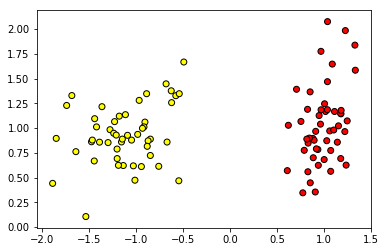

In [ ]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=1)
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='black')

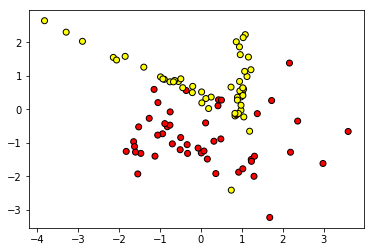

In [ ]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=2, random_state=2)
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='black')

## Визуализация решающего правила

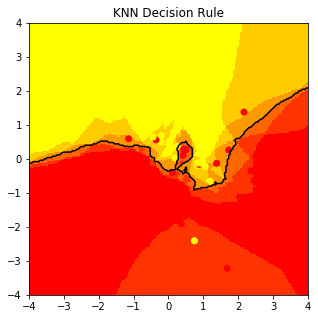

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X, y)

figure(figsize=(5, 5))
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')

xvals = linspace(-4, 4, 200)
yvals = linspace(-4, 4, 200)

xx, yy = np.meshgrid(xvals, yvals)
zz = np.reshape(model.predict_proba(c_[xx.ravel(), yy.ravel()])[:, 1], xx.shape)

# Цветной фон, соответствующий значению решающего правила
pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

# Линия уровня, соответствующая значению 0.5
contour(xx, yy, zz, levels=(0.5,), colors='k', linewidths=1.5, zorder=1)

xlim([-4, 4])
ylim([-4, 4])
_ = title('KNN Decision Rule')

## Реализация собственной модели для SciKit-Learn

В заданиях 2 и 3 требуется самостоятельно реализовать алгоритм обучения классификатора. Для того чтобы ваш алгоритм можно было использовать различными компонентами библиотеки SciKit-Learn (оценка качества, подбор параметров, композиции и т.д.) нужно всего лишь [реализовать интерфейс `BaseEstimator`](http://scikit-learn.org/stable/developers/#estimators).

In [ ]:
from sklearn.base import BaseEstimator

class LinearSVM(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform

    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        dim = X.shape[1]
        self.weights_ = empty(dim)
        self.bias_ = 0
        raise NotImplementedError()

    def predict_proba(self, X):
        return (dot(X, self.weights_) + self.bias_).flatten()

    def predict(self, X):
        return sign(self.predict_proba(X))

In [ ]:
from sklearn.base import BaseEstimator

class DualSVM(BaseEstimator):
    def __init__(self, C, kernel=None):
        self.C = C
        self.kernel = kernel

    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        self.dim = X.shape[1]
        self.N = X.shape[0]
        self.alpha_ = empty(self.N)
        self.bias_ = 0
        raise NotImplementedError()

    def predict_proba(self, X):
        pass

    def predict(self, X):
        pass